In [1]:
import json
import ijson
import logging

import numpy as np

from decimal import Decimal
from pathlib import Path
from typing import List, Tuple

from src.utils.data import *
from src.utils.plots import *
from src.utils.sampling import *
from src.utils.memory_management import *
from src.utils.statistics_utils import *

Setting up Logger

In [2]:
# Set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create a console handler
sh = logging.StreamHandler()
sh.setLevel(logging.INFO)
# Add the handler to the logger
logger.addHandler(sh)

Loading the `ConfigParser` for paths

In [3]:
from src.configs.config_parser import PathConfigParser, data_config_file, project_root

# Configs Directory
parser = PathConfigParser(str(data_config_file))
parser.load()

In [4]:
# Data Paths
PROCESSED_DATA_PATH = project_root / parser.get("data_paths", {}).get("processed_data")
GE_PATH = parser.get("data_paths", {}).get("brain_regions_genes_ge")
PROCESSED_DONORS_GE_PATH = PROCESSED_DATA_PATH / GE_PATH

# Donors_ids
DONORS_IDS = parser.get("donors_ids")

Loading the Meta Donor DataFrame

In [5]:
meta_donor_csv_pth = PROCESSED_DONORS_GE_PATH / Path("meta_donor.csv")
meta_donor_df = load_df_from_csv(meta_donor_csv_pth)
meta_donor_df.head(3)

,brain_region,gene_id,gene_expression_values
0,4012,2,"[1.58747780630413, 7.567907786636231, 1.495682..."
1,4012,3,"[5.11909080343638, 9.66921569197332, 10.081154..."
2,4012,6,"[1.83564765363665, 1.4949501777457102, 5.94151..."


Converting the gene_expression_values from a stored string to a list

In [6]:
meta_donor_df["gene_expression_values"]=meta_donor_df["gene_expression_values"].apply(json.loads)
logger.info(meta_donor_df["gene_expression_values"][0][0])

1.58747780630413


In [7]:
geneid_H0 = calculate_gene_mean_expression_values(meta_donor_df)

logger.info(geneid_H0.head(5))
logger.info(f"Number of Total Sample Count == {geneid_H0['total_sample_count'].sum() == get_total_number_of_samples(meta_donor_df)}")

   gene_id  total_expression  total_sample_count  weighted_mean
0        2      16227.834876                3936       4.122926
1        3      66283.660534                7872       8.420180
2        6      41203.873837               13776       2.990990
3        7      19101.630752                3936       4.853057
4        9      21518.755199                7872       2.733582
Number of Total Sample Count == True


Histogram of Mean Expression Values per Gene

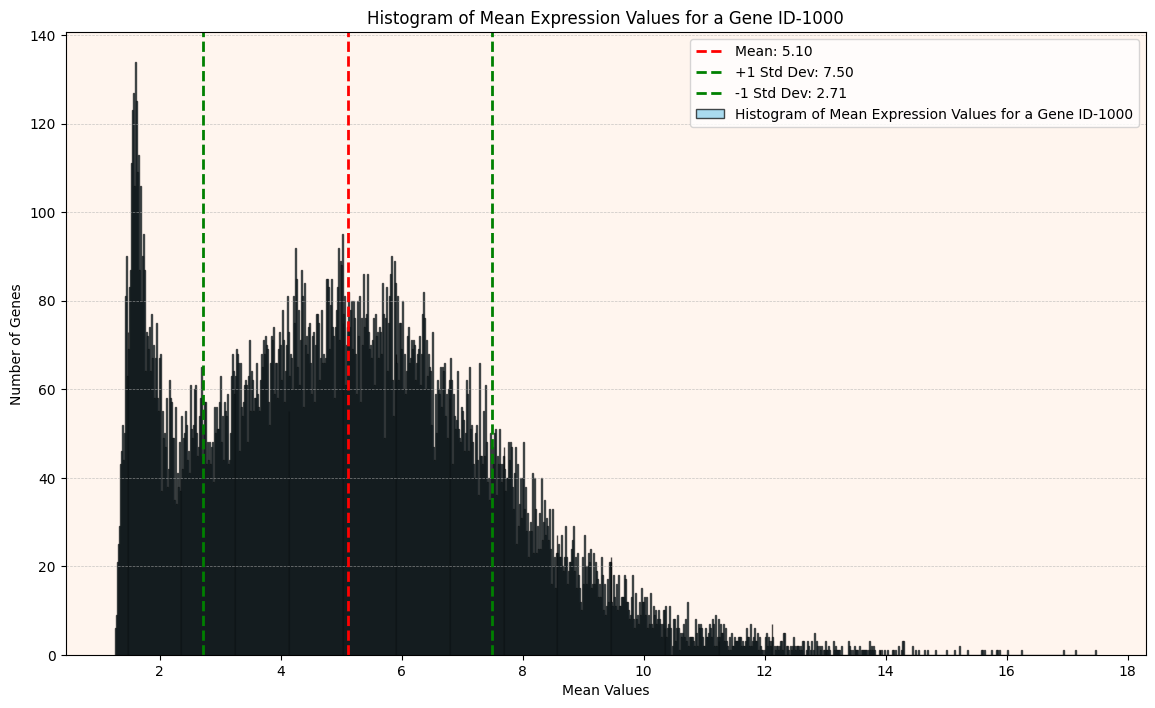

In [11]:
plot_histogram(geneid_H0["weighted_mean"], plot_title="Histogram of Mean Expression Values for a Gene ID-1000", 
               x_title="Mean Values", y_title="Number of Genes", bins=1000, save=True)

In [9]:
meta_donor_df[(meta_donor_df['brain_region'] == 4012) & (meta_donor_df['gene_id'] == 6)]["gene_expression_values"].to_list()[0]

[1.83564765363665,
 1.4949501777457102,
 5.94151644422237,
 2.75842448915876,
 2.12164438391981,
 4.8524371104519,
 1.91931620336191,
 1.47672544604743,
 1.55935125347395,
 7.123027880475241,
 1.64941775646033,
 1.52098732812331,
 4.30078926593806,
 1.6740993148970202,
 1.3820070686893602,
 1.27904901485058,
 6.124668768572881,
 3.01680677082369,
 1.62005211771626,
 4.66992787007965,
 2.59153481130918,
 1.462165709981,
 1.4146220685759,
 7.1364593626001405,
 3.03829943507971,
 1.4241541092033,
 4.34529979210363,
 1.48480170120334,
 1.33843054100719,
 2.29427091923417,
 7.134900704011969,
 1.50324610027603,
 2.44143070335491,
 4.54464558918872,
 2.1160004380138,
 1.40776497031674,
 2.00504225983637,
 7.217253660410381,
 2.26952247898252,
 1.9463194497674503,
 4.90198399495094,
 1.7215768617155298,
 1.61297178801442,
 1.36832668405292,
 6.11087491068117,
 1.9790584935118103,
 1.84018373543091,
 4.2821451104345,
 1.85041038822466,
 0.9408429432997752,
 1.49973540399199,
 8.01342097932989,

Student's One Sample T Test

In [14]:
from scipy.stats import ttest_1samp
import numpy as np

# Extract the values for one of the groups
sample_size = 30
gene_id = 2

sample = get_br_ge_sample(meta_donor_df, br=4012, ge=gene_id)
print(len(sample))

# TODO Check Sample Size
sample = sample[:sample_size]

# Specify the value to compare against (e.g., the mean of another group)
control_group_mean = geneid_H0.loc[geneid_H0["gene_id"] == int(gene_id), "weighted_mean"].iloc[0]

# Perform a one-sample t-test
t_stat, p_value = ttest_1samp(sample, control_group_mean, alternative='greater')

# Display the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Compare the mean directly
sample_mean = np.mean(sample)
print(f"Sample Mean: {control_group_mean}")
print(f"Control Group Mean: {control_group_mean}")


22
T-statistic: 0.6416016058853322
P-value: 0.5280735059266324
Sample Mean: 4.122925527394228
Control Group Mean: 4.122925527394228


Visualizing the Comparison:

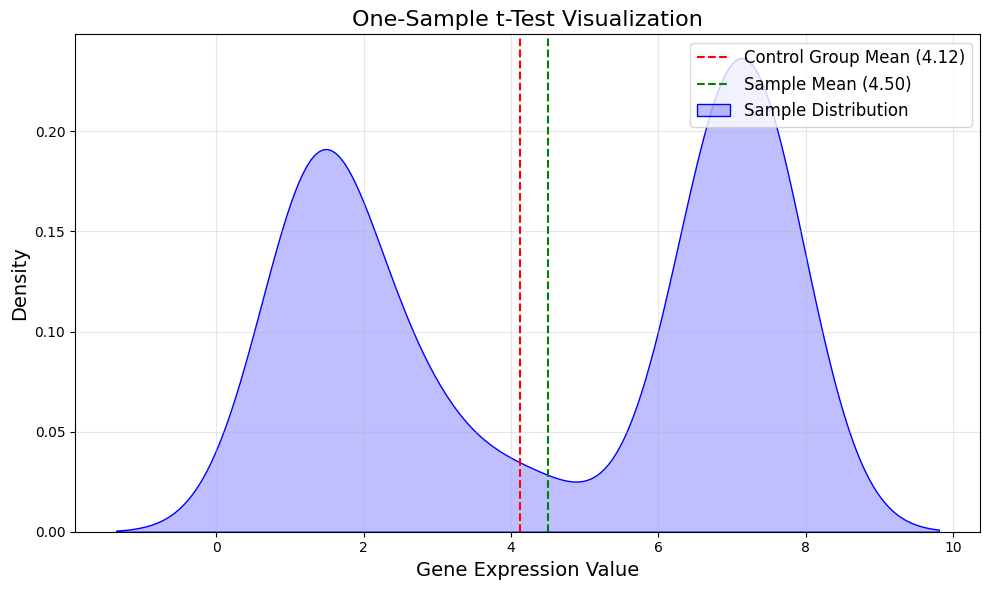

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(sample, label='Sample Distribution', shade=True, color='blue', bw_adjust=0.5)

# Add a vertical line for the group 3 mean
plt.axvline(control_group_mean, color='red', linestyle='--', label=f'Control Group Mean ({control_group_mean:.2f})')
plt.axvline(sample_mean, color='green', linestyle='--', label=f'Sample Mean ({sample_mean:.2f})')

# Add labels and legend
plt.title('One-Sample t-Test Visualization', fontsize=16)
plt.xlabel('Gene Expression Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()
